In [37]:
#model tracking
import dagshub
import mlflow

#data mmanipulation
import numpy as np
import pandas as pd

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

#model building
from scipy.stats import zscore, norm
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#class imbalance
from imblearn.over_sampling import SMOTE

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os

os.environ['MODEL_TRACKING_URI']= f"https://dagshub.com/iamchetan-ds/personal-loan-modeling.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'iamchetan-ds'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'b92c73171551125b265def04bf0897d3797472c9'

In [5]:
##setting up remote tracking server
MLFLOW_TRACKING_URI='https://dagshub.com/iamchetan-ds/personal-loan-modeling.mlflow'
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [6]:
def get_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
        exp_id = mlflow.create_experiment(name)
        return exp_id
    return exp.experiment_id

In [7]:
print(get_experiment_id('loan-modeling'))

0


In [94]:
df = pd.read_csv('../data/cleaned-train.csv')
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,43,19,70,3,2.33,1,0,0,0,0,1,0
1,62,36,83,4,2.40,3,0,0,1,0,0,0
2,39,14,61,3,0.50,3,137,0,0,0,1,0
3,56,32,23,4,0.70,1,0,0,0,0,1,1
4,58,34,151,3,0.60,2,0,1,0,0,0,0


In [95]:
X = df.drop(columns=['Personal Loan'])
y = df['Personal Loan']

In [96]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=42,
                                                    stratify=y)

In [97]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()

x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

In [98]:
metric_graphs = []

## Baseline (Dummy) classifier

In [99]:
def get_metrics(clf_name, y_true, y_pred):

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    name = f'{clf_name}-confusionMatrix.png'
    metric_graphs.append(name)

    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.grid(False)
    plt.savefig(f"../graphs/{name}")
    plt.show()

    return (precision, recall, accuracy, f1)


In [100]:
def roc_plt(clf_label, y_test, y_proba): 
    fpr, tpr, thresholds= roc_curve(y_test,y_proba[:,1])

    plt.plot(fpr, tpr, label = f'{clf_label}')
    plt.plot([0,1],[0,1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {clf_label}')
    plt.legend()

    name = f'{clf_label}-ROC.png'
    metric_graphs.append(name)
    plt.savefig(f'../graphs/{name}')
    plt.show()

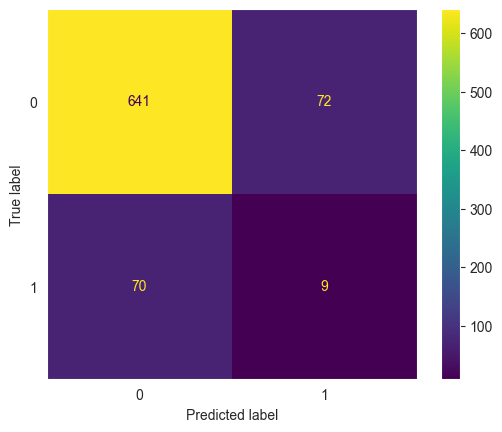

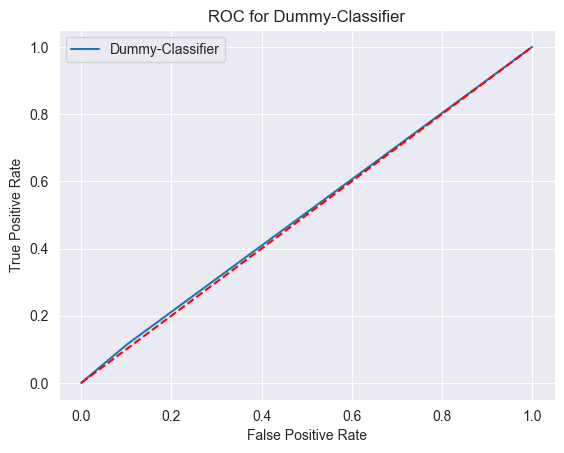

In [101]:
from sklearn.dummy import DummyClassifier

mlflow.set_experiment(experiment_id=0)
with mlflow.start_run(run_name='Dummy Classifier', nested=True) as dummy:
    #creating dummy classifier
    dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
    mlflow.log_param('Strategy', 'stratified')

    dummy_clf.fit(x_train, y_train)
    dummy_pred = dummy_clf.predict(x_test)
    dummy_proba = dummy_clf.predict_proba(x_test)

    prec, recall, acc, f1 = get_metrics('dummy', y_test, dummy_pred)
    roc_plt('Dummy-Classifier', y_test, dummy_proba)
    
    mlflow.log_metric('precision', prec)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1-score', f1)

## Logistic Regression

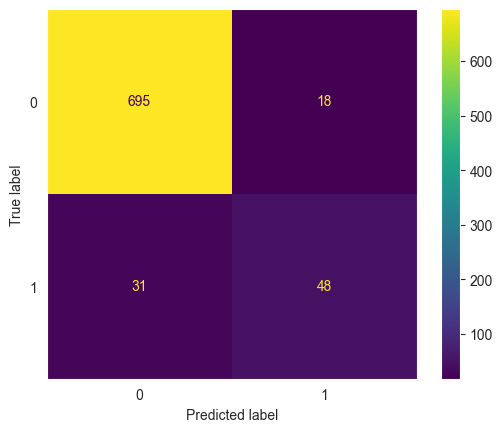

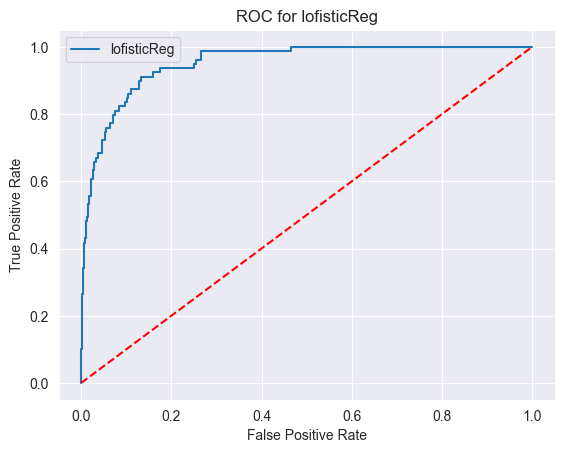

Precision: 0.7272727272727273  Recall: 0.6075949367088608  Accuracy: 0.9381313131313131   f1_score: 0.6620689655172415
          


In [102]:
## lr without hyperparameter tuning

with mlflow.start_run(run_name = 'Logistic Regression', nested=True):
    penalty = 'l2'
    C = 1.0
    solver = 'lbfgs'

    mlflow.log_param('penalty', penalty)
    mlflow.log_param('C', 1.0)
    mlflow.log_param('solver',solver)

    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    lr_pred = lr.predict(x_test)
    lr_proba = lr.predict_proba(x_test)

    prec, recall, acc, f1 = get_metrics('lofisticReg', y_test, lr_pred)
    roc_plt('lofisticReg', y_test, lr_proba)

    print(f"""Precision: {prec}  Recall: {recall}  Accuracy: {acc}   f1_score: {f1}
          """)
    
    mlflow.log_metric('precision', prec)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1-score', f1)

    mlflow.sklearn.log_model(lr, 'Logistic Regression')

    

## optimized Logisitc Regression


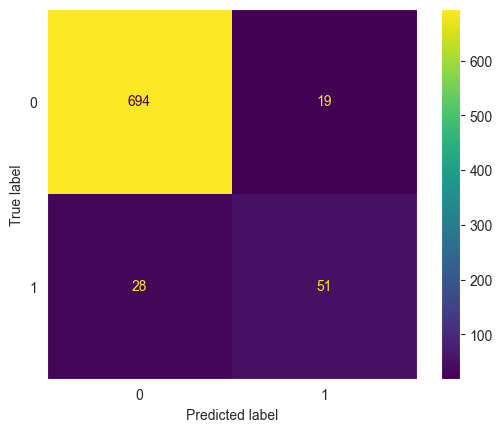

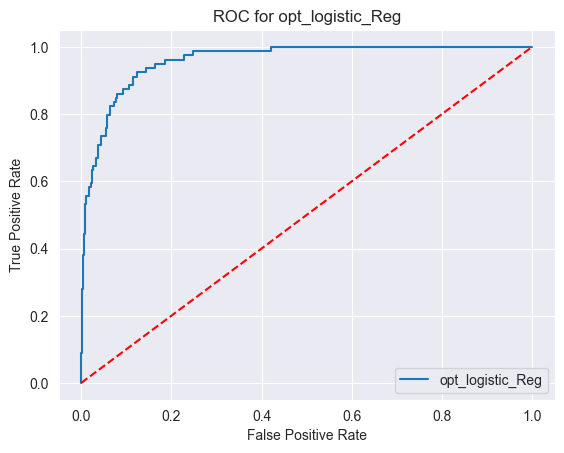

Precision: 0.7285714285714285  Recall: 0.6455696202531646  Accuracy: 0.9406565656565656   f1_score: 0.6845637583892618


In [103]:
##hyperparameter optimization
lr_o = LogisticRegression(random_state=42)

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1,10,100],
    'solver': ['lbfgs', 'liblinear']
}

skf = StratifiedKFold(n_splits=10)

lr_opt = GridSearchCV(lr_o, 
                      param_grid=params, 
                      cv= skf)

lr_opt.fit(x_train, y_train)
lr_o_pred = lr_opt.predict(x_test)
lr_o_proba = lr_opt.predict_proba(x_test)

prec, recall, acc, f1 = get_metrics('opt_logistic_Reg', y_test, lr_o_pred)
roc_plt('opt_logistic_Reg', y_test, lr_o_proba)

print(f"""Precision: {prec}  Recall: {recall}  Accuracy: {acc}   f1_score: {f1}""")




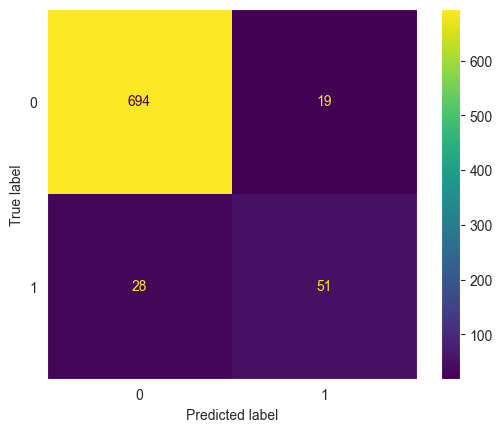

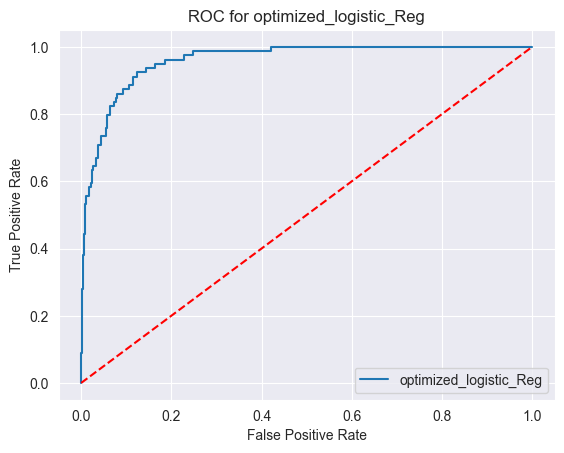

Precision: 0.7285714285714285  Recall: 0.6455696202531646  Accuracy: 0.9406565656565656   f1_score: 0.6845637583892618
          


In [104]:
param = lr_opt.best_params_
with mlflow.start_run(run_name = 'Optimized Logistic Regression', nested=True):
    
    for key in param.keys():
        mlflow.log_param(key, param[key])
    
    lr = LogisticRegression(**param)
    lr.fit(x_train, y_train)
    lr_pred = lr.predict(x_test)
    lr_proba = lr.predict_proba(x_test)

    prec, recall, acc, f1 = get_metrics('optimized_logistic_Reg', y_test, lr_pred)
    roc_plt('optimized_logistic_Reg', y_test, lr_proba)

    print(f"""Precision: {prec}  Recall: {recall}  Accuracy: {acc}   f1_score: {f1}
          """)
    
    mlflow.log_metric('precision', prec)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1-score', f1)

    mlflow.sklearn.log_model(lr, 'Optimized Logistic Regression')

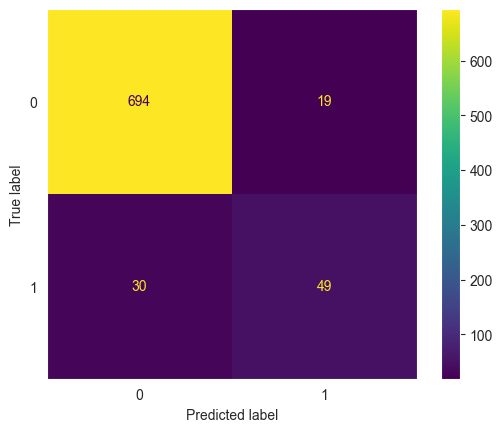

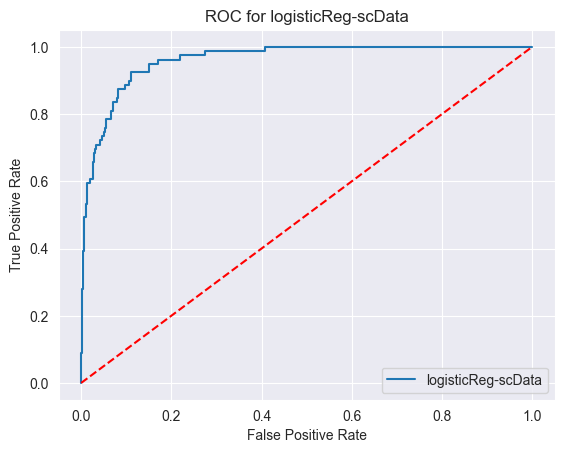

Precision: 0.7205882352941176  Recall: 0.620253164556962  Accuracy: 0.9381313131313131   f1_score: 0.6666666666666666
          


In [105]:
with mlflow.start_run(run_name = 'Logistic Regression- Standardized Data', nested=True):
    
    for key in param.keys():
        mlflow.log_param(key, param[key])
    
    lr = LogisticRegression(**param)
    lr.fit(x_train_scaled, y_train)
    lr_pred = lr.predict(x_test_scaled)
    lr_proba = lr.predict_proba(x_test_scaled)

    prec, recall, acc, f1 = get_metrics('logisticReg-scData', y_test, lr_pred)
    roc_plt('logisticReg-scData', y_test, lr_proba)

    print(f"""Precision: {prec}  Recall: {recall}  Accuracy: {acc}   f1_score: {f1}
          """)
    
    mlflow.log_metric('precision', prec)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1-score', f1)

    mlflow.sklearn.log_model(lr, 'Logistic Regression- Standardized Data')

## K-Nearest Neighbor Classifier

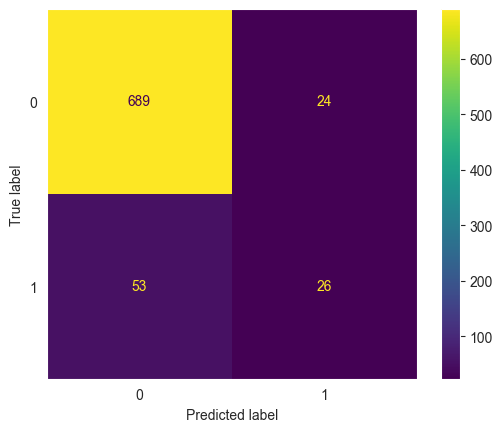

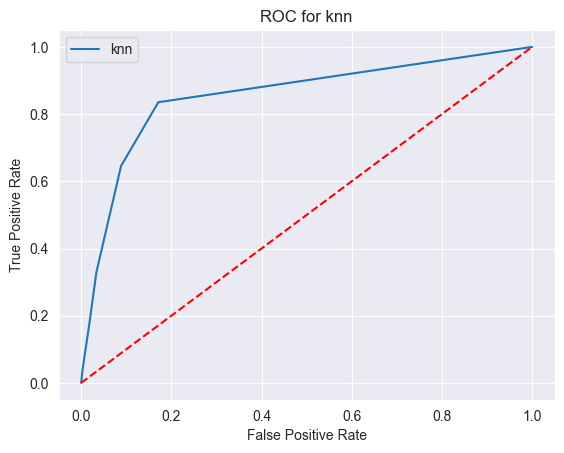

Precision: 0.52  Recall: 0.3291139240506329  Accuracy: 0.9027777777777778   f1_score: 0.40310077519379844
          


In [106]:
##without-scaled data
with mlflow.start_run(run_name= 'KNN', nested= True):

    n_neighbors=5
    weights='uniform'
    algorithm='auto'

    mlflow.log_param('n_neighbors', n_neighbors)
    mlflow.log_param('weights', weights)
    mlflow.log_param('algorithm', algorithm)

    knn = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                               algorithm='auto')
    knn.fit(x_train, y_train)

    knn_pred = knn.predict(x_test)
    knn_proba = knn.predict_proba(x_test)

    prec, recall, acc, f1 = get_metrics('knn', y_test, knn_pred)
    roc_plt('knn', y_test, knn_proba)

    print(f"""Precision: {prec}  Recall: {recall}  Accuracy: {acc}   f1_score: {f1}
          """)
    
    mlflow.log_metric('precision', prec)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1-score', f1)

    mlflow.sklearn.log_model(knn, 'KNN')

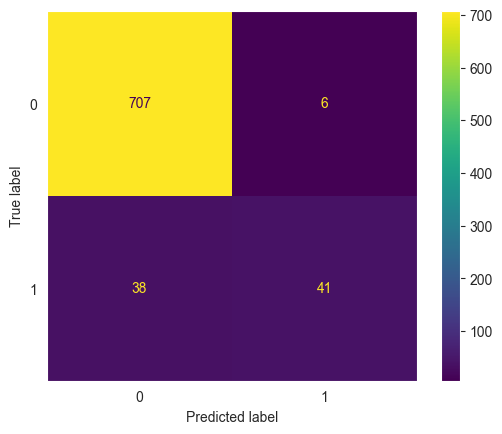

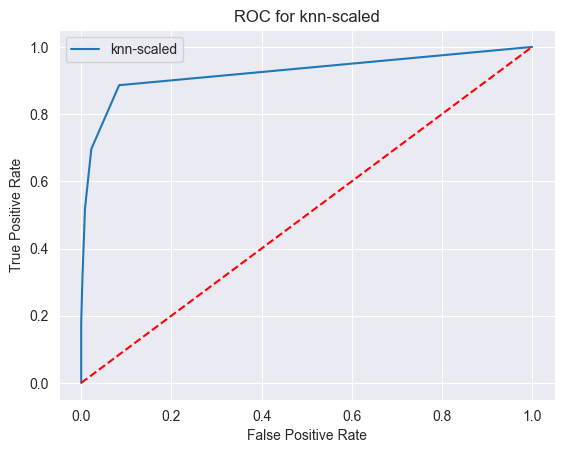

Precision: 0.8723404255319149  Recall: 0.5189873417721519  Accuracy: 0.9444444444444444   f1_score: 0.6507936507936507
          


In [107]:
##with scaled data
with mlflow.start_run(run_name= 'KNN-Scaled Data', nested= True):

    n_neighbors=5
    weights='uniform'
    algorithm='auto'

    mlflow.log_param('n_neighbors', n_neighbors)
    mlflow.log_param('weights', weights)
    mlflow.log_param('algorithm', algorithm)

    knn = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                               algorithm='auto')
    knn.fit(x_train_scaled, y_train)

    knn_pred = knn.predict(x_test_scaled)
    knn_proba = knn.predict_proba(x_test_scaled)

    prec, recall, acc, f1 = get_metrics('knn-scaled', y_test, knn_pred)
    roc_plt('knn-scaled', y_test, knn_proba)

    print(f"""Precision: {prec}  Recall: {recall}  Accuracy: {acc}   f1_score: {f1}
          """)
    
    mlflow.log_metric('precision', prec)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1-score', f1)

    mlflow.sklearn.log_model(knn, 'KNN-Scaled Data')

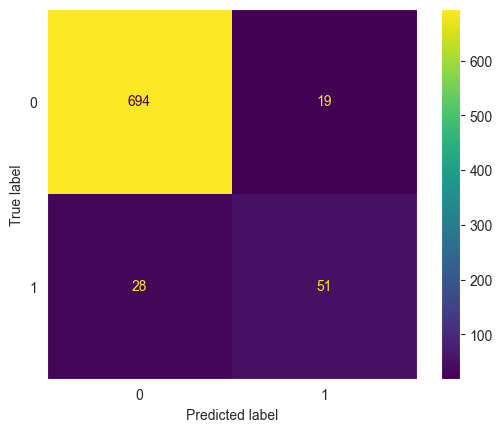

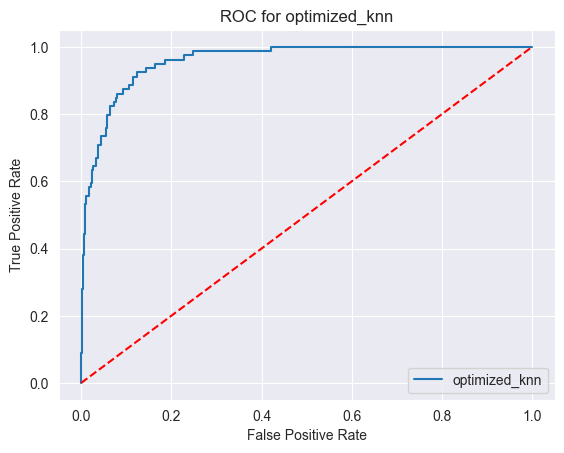

Precision: 0.7285714285714285  Recall: 0.6455696202531646  Accuracy: 0.9406565656565656   f1_score: 0.6845637583892618


In [108]:
knn = KNeighborsClassifier()
param = {
    'n_neighbors': list(range(1,40,2)),
    'weights':['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}

skf = StratifiedKFold(n_splits= 10, random_state=42, shuffle=True)

knn_hyper= GridSearchCV(knn, param_grid=param, cv = skf)
knn_hyper.fit(x_train_scaled, y_train)

knn_hyper_pred = lr_opt.predict(x_test_scaled)
knn_hyper_proba = lr_opt.predict_proba(x_test_scaled)

prec, recall, acc, f1 = get_metrics('optimized_knn', y_test, lr_o_pred)
roc_plt('optimized_knn', y_test, lr_o_proba)

print(f"""Precision: {prec}  Recall: {recall}  Accuracy: {acc}   f1_score: {f1}""")

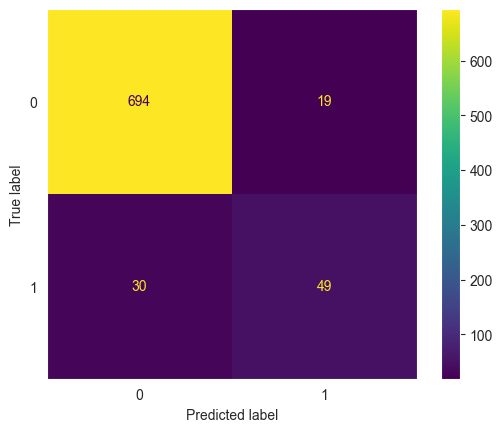

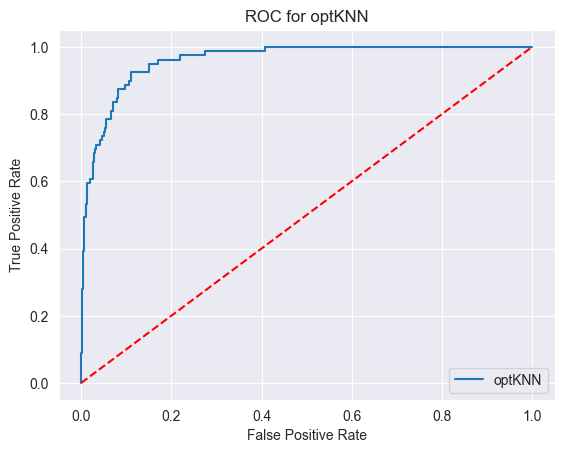

Precision: 0.7205882352941176  Recall: 0.620253164556962  Accuracy: 0.9381313131313131   f1_score: 0.6666666666666666
          


In [109]:
params = knn_hyper.best_params_
with mlflow.start_run(run_name = 'Optimized KNN', nested=True):
    
    for key in param.keys():
        mlflow.log_param(key, param[key])
    
    knn = KNeighborsClassifier(**params)
    knn.fit(x_train_scaled, y_train)

    knn_pred = knn.predict(x_test_scaled)
    knn_proba = knn.predict_proba(x_test_scaled)

    prec, recall, acc, f1 = get_metrics('optKNN', y_test, lr_pred)
    roc_plt('optKNN', y_test, lr_proba)

    print(f"""Precision: {prec}  Recall: {recall}  Accuracy: {acc}   f1_score: {f1}
          """)
    
    mlflow.log_metric('precision', prec)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('f1-score', f1)

    mlflow.sklearn.log_model(lr, 'Optimized KNN')